Welcome to this hands-on lab for **Adding GitHub Triggers**.

Running a pipeline manually has limited uses. In this lab you will create a Tekton Trigger to cause a pipeline run from external events like changes made to a repo in GitHub.

# Learning Objective

After completing this lab, you will be able to:
* Create an `EventListener`, a `TriggerBinding` and a `TriggerTemplate`
* State how to trigger a deployment when changes are made to github

# Set Up the Lab Environment

## Clone the Code Repo

Now, get the code that you need to test. 

To do this, use the `git clone` command to clone the Git repository:
```
git clone https://github.com/ibm-developer-skills-network/wtecc-CICD_PracticeCode.git
```

Your output should look similar to the image below:

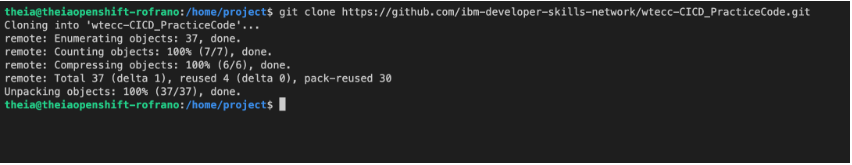

## Change to the Labs Directory

Once you have cloned the repository, change to the labs directory.
```
cd wtecc-CICD_PracticeCode/labs/02_add_git_trigger/
```

## Navigate to the Lab Folder

Navigate to the `labs/02_add_git_trigger` folder in left explorer panel. 

All of your work will be with the files in this folder.

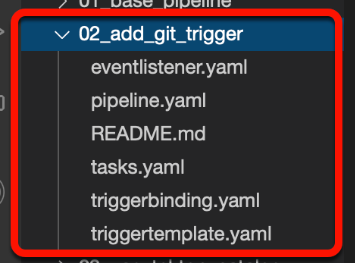

You are now ready to start the lab.

# Prerequisites

This lab starts with the `cd-pipeline` pipeline and `checkout` and `echo` tasks from the previous lab.

If you did not complete the previous lab, you should apply them to your Kubernetes cluster before starting this lab:

**Issue the following commands to install everything from the previous labs.**

```
kubectl apply -f tasks.yaml
kubectl apply -f pipeline.yaml
```

**Check that the tasks were created:**

```
tkn task ls
```

**You should see output similar to this:**

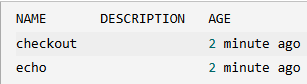

**Check that the pipeline was created:**
```
tkn pipeline ls
```

**You should see output similar to this:**

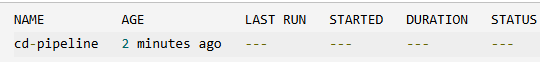

You are now ready to continue with this lab.

# Step 1: Create an EventListener

The first thing you need is an event listener that is listening for incoming events from GitHub.

You will update the `eventlistener.yaml` file to define an `EventListener` named `cd-listener` that references a `TriggerBinding` named `cd-binding` and a `TriggerTemplate` named `cd-template`.

It should initially look like this:

```
apiVersion: triggers.tekton.dev/v1beta1
kind: EventListener
metadata:
  name: <place-name-here>
spec:
```

## Your Task

1. The first thing you want to do is give the EventListener a good name. Change `<place-name-Here>` to `cd-listener`.
2. The next thing is to add a service account. Add a `serviceAccountName:` with a value of `pipeline` to the `spec` section.
3. Now you need to define the triggers.
    * Add a `triggers:` section under `spec:`.
    * This is where you will define the bindings and template.
4. Add a `bindings:` section under the `triggers:` section with a `ref:` to `cd-binding`. 
    * Since there can be mutiple triggers, make sure you define `- bindings` as a list using the dash `-` prefix.
    * Also since there can be multiple bindings, make sure you defne the `- ref:` with a dash `-` prefix as well.
5. Add a `template:` section at the same level as `bindings` with a `ref:` to `cd-template`.

## Solution

```
apiVersion: triggers.tekton.dev/v1beta1
kind: EventListener
metadata:
  name: cd-listener
spec:
  serviceAccountName: pipeline
  triggers:
    - bindings:
      - ref: cd-binding
      template:
        ref: cd-template
```

**Apply the `EventListener` resource to the cluster:** `kubectl apply -f eventlistener.yaml`

**Check that it was created correctly:** `tkn eventlistener ls`

**You should see a reply similar to this:**

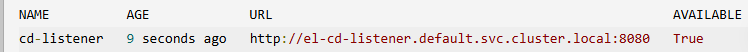

You will create the `TriggerBinding` named `cd-binding` and a `TriggerTemplate` named `cd-template` in the next steps.

# Step 2: Create a TriggerBinding

The next thing you need is a way to bind the incoming data from the event to pass on to the pipeline. 

To accomplish this, you use a `TriggerBinding`.

Update the `triggerbinding.yaml` file to create a `TriggerBinding` named `cd-binding` that takes the `body.repository.url` and `body.ref` and binds them to the parameters `repository` and `branch`, respectively.

It should initially look like this:

```
apiVersion: triggers.tekton.dev/v1beta1
kind: TriggerBinding
metadata:
  name: <place-name-here>
spec:
```

## Your Task

1. The first thing you want to do is give the `TriggerBinding` the same name that is referenced in the `EventListener`, which is `cd-binding`.
2. Next, you need to add a parameter named `repository` to the `spec:` section with a value that references `$(body.repository.url)`.
3. Finally, you need to add a parameter named `branch` to the `spec:` section with a value that references `$(body.ref)`.

## Solution

```
apiVersion: triggers.tekton.dev/v1beta1
kind: TriggerBinding
metadata:
  name: cd-binding
spec:
  params:
    - name: repository
      value: $(body.repository.url)
    - name: branch
      value: $(body.ref)
```

**Apply the new `TriggerBinding` definition to the cluster:** `kubectl apply -f triggerbinding.yaml`

# Step 3: Create a TriggerTemplate

The `TriggerTemplate` takes the parameters passed in from the `TriggerBinding` and creates a `PipelineRun` to start the pipeline.

Update the `triggertemplate.yaml` file to create a `TriggerTemplate` named `cd-template` that defines the parameters required, and create a `PipelineRun` that will run the `cd-pipeline` you created in the previous lab.

It should initially look like this:

```
apiVersion: triggers.tekton.dev/v1beta1
kind: TriggerTemplate
metadata:
  name: <place-name-here>
spec:
  params:
  # Add parameters here
  resourcetemplates:
    - apiVersion: tekton.dev/v1beta1
      kind: PipelineRun
      metadata:
        generateName: cd-pipeline-run-
      spec:
      # Add pipeline definition here
```

## Your Task

You must update the parameter section of the `TriggerTemplate` and fill out the `resourcetemplates` section

**Update Name and Add Parameters**
1. The first thing you want to do is give the `TriggerTemplate` the same name that is referenced in the `EventListener`, which is `cd-template`.
2. Next, you need to add a parameter named `repository` to the `spec:` section with a `description:` of **"The git repo"** and a `default:` of `" "`.
3. Then, you need to add a parameter named `branch` to the `spec:` section with a `description:` of **"the branch for the git repo"** and a `default:` of `master`.

**Complete the Resource Template**

Finish filling out the `resourcetemplates:` section by adding the following after the commented line `# Add pipeline definition here`.
1. Add a `serviceAccountName:` with a value of pipeline.
2. Add a `pipelineRef:` that refers to the `cd-pipeline` created in the last lab.
3. Add a parameter named `repo-url` with a value referencing the **TriggerTemplate** `repository` parameter above.
4. Add a second parameter named `branch` with a value referencing the **TriggerTemplate** `branch` parameter above.

## Solution

```
apiVersion: triggers.tekton.dev/v1beta1
kind: TriggerTemplate
metadata:
  name: cd-template
spec:
  params:
    - name: repository
      description: The git repo
      default: " "
    - name: branch
      description: the branch for the git repo
      default: master
  resourcetemplates:
    - apiVersion: tekton.dev/v1beta1
      kind: PipelineRun
      metadata:
        generateName: cd-pipeline-run-
      spec:
        serviceAccountName: pipeline
        pipelineRef:
          name: cd-pipeline
        params:
          - name: repo-url
            value: $(tt.params.repository)
          - name: branch
            value: $(tt.params.branch)
```

> *Note that while the parameter you bound from the event is `repository`, you pass it on as `repo-url` to the pipeline. This is to show that the names do not have to match, allowing you to use any pipeline to map parameters into.*

**Apply the new TriggerTemplate definition to the cluster:** `kubectl apply -f triggertemplate.yaml`

# Step 4: Start a Pipeline Run

Now it is time to call the event listener and start a `PipelineRun`. 

You can do this locally using the `curl` command to test that it works.

For this last step, you will need **two terminal sessions**.

## Terminal 1

In one of the sessions, you need to run the `kubectl port-forward` command to forward the port for the event listener so that you can call it on `localhost`.

**Use the `kubectl port-forward` command to forward port `8090` to `8080`**.

```
kubectl port-forward service/el-cd-listener  8090:8080
```

**You will see the following output, but you will not get your cursor back.**

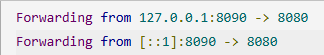


## Terminal 2

Now you are ready to trigger the event listener by posting to the endpoint that it is listening on. 

You will now need to open a second terminal shell to issue commands.
1. Open a new Terminal shell wtih the menu item `Terminal > New Terminal`.
2. Use the `curl` command to send a payload to the event listener service.

```
curl -X POST http://localhost:8090 \
  -H 'Content-Type: application/json' \
  -d '{"ref":"main","repository":{"url":"https://github.com/ibm-developer-skills-network/wtecc-CICD_PracticeCode"}}'
```

**This should start a `PipelineRun`.** 

**You can check on the status with this command:** `tkn pipelinerun ls`

**You should see something like this come back:**

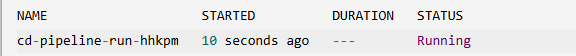

You can also examine the `PipelineRun` logs using this command (the `-L` means **"latest"** so that you do not have to look up the name for the last run): 

```
tkn pipelinerun logs --last
```

**You should see:**

```
[clone : checkout] Cloning into 'wtecc-CICD_PracticeCode'...

[lint : echo-message] Calling Flake8 linter...

[tests : echo-message] Running unit tests with PyUnit...

[build : echo-message] Building image for https://github.com/ibm-developer-skills-network/wtecc-CICD_PracticeCode ...

[deploy : echo-message] Deploying master branch of https://github.com/ibm-developer-skills-network/wtecc-CICD_PracticeCode ...
```